In [1]:
# Bring your packages onto the path
import sys, os
# include directory 3 levels up 
# for 1 level up '..' 
# for 2 levels '../..'
sys.path.append(os.path.abspath(os.path.join('../..')))

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm # module for progress bar (https://pypi.org/project/tqdm/)

# custom module where all models are written
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator # model
from Models.Mechanical_Oscillator.mechanical_oscillator import mech_oscillator_samples # sample generator

# Mechanical Oscillator

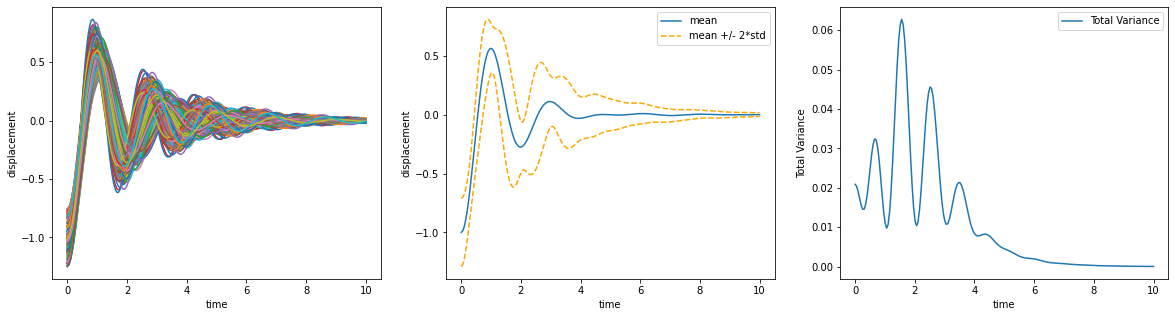

In [3]:
n = 20_000 # number of 'instances'/'realisations'
N = 200  # discretization in time

t = np.linspace(0,10,N) # row vector
T = np.tile(t, (n, 1)) # repeat row 't' along axis 0

X = mech_oscillator_samples(n)
Y = mech_oscillator(X, T)

Y_mean = np.mean(Y, axis=0) # compute mean for each t_i
Y_var = np.var(Y, axis=0) # compute var for each t_i
Y_std = np.std(Y, axis=0) # compute std for each t_i

'Plots'
fig, ax = plt.subplots(1, 3, figsize=(20,5))

'Plot 200 realisations of the random process'
for i in np.arange(200):
    ax[0].plot(t,Y[i,:], '-')
ax[0].set_ylabel('displacement')
ax[0].set_xlabel('time')

'Plot the mean and 2 stds of random process'
ax[1].plot(t,Y_mean, '-', label = 'mean')
ax[1].plot(t,Y_mean+2*Y_std, '--', color = 'orange', label = 'mean +/- 2*std')
ax[1].plot(t,Y_mean-2*Y_std, '--', color = 'orange')
ax[1].set_ylabel('displacement')
ax[1].set_xlabel('time')
ax[1].legend()

'Plot the variance of random process'
ax[2].plot(t, Y_var, '-', label = 'Total Variance')
ax[2].set_ylabel('Total Variance')
ax[2].set_xlabel('time')
ax[2].legend()

plt.show()

# Gauß-Legendre Quadrature 

Exactly integrates polynomial of degree: 2*number_of_quadrature_points-1

numpy package has been tested upto 100 points

In [4]:
def GaussLegendreQuadrature(lowerlimit, upperlimit, number_of_quadrature_points):

    # numpy method that provides Gauß-Legendre quadrature points and weights 
    quad_points, quad_weights = np.polynomial.legendre.leggauss(number_of_quadrature_points)

    # scaling for change of interval from [-1, 1] to [a, b]
    quad_points = ( (upperlimit-lowerlimit)/2 ) * quad_points + ( (upperlimit+lowerlimit)/2 )
    quad_weights = ( (upperlimit-lowerlimit)/2 ) * quad_weights

    return quad_points, quad_weights

# Generalised Sobol Indices

In [24]:
def generalised_sobol_indices(model, A, B, N, t_max, N_quad):

    '''
    Inputs:

    model = function that returns model output for given input
    t = t_i = time to at which model must be evaluated
    A = First set of inputs of size [N,N_p]
    B = Second set of inputs of size [N,N_p] 
    Q = number of temporal quadrature points

    Outputs:

    G_U = Generalised First order Sobol Indices of size [N_p,Q]
    G_total_U = Generalised Total Sobol Indices of size [N_p,Q]

    '''
    N_p = 3

    quad_points, quad_weights = GaussLegendreQuadrature(0, t_max, N_quad)

    def get_C_i(i):
        C_i = np.copy(B)
        C_i[:,i] = A[:,i]
        return C_i

    T = np.tile(quad_points, (N, 1)) # repeat row 't' along axis 0

    f_A = model(A, T).T # [n_t, N] vector with evaluations at x_A
    f_B = model(B, T).T # [n_t, N] vector with evaluations at x_B

    # store f_C
    f_C = np.zeros((f_A.shape[0], f_A.shape[1], N_p)) # [n_t, N, N_p] 3d array with evaluations at x_C_i

    for i in range(N_p):
        f_C[:, :, i] = model(get_C_i(i), T).T # [n_t, N] vector with evaluations at x_C_i

    G_U = np.zeros((N_p)) # store first order sensitivity for each parmeter for each point in time
    G_total_U = np.zeros((N_p)) # store total sensitivity for each parmeter for each point in time

    for i in range(N_p):

        D_t = 0 # denominator
        D_U = 0 # numerator first order indices
        D_U_c = 0 # numerator total order indices

        for k, t_m in enumerate(quad_points):
            
            f_A_t = f_A[k, :]
            f_B_t = f_B[k, :]
            f_C_t_i = f_C[k, :, i]

            f_mean_t = np.mean(f_A_t)

            D_t += ( (np.dot(f_A_t,f_A_t)/N) - f_mean_t**2 ) * quad_weights[k]

            D_U += ( (np.dot(f_A_t,f_C_t_i)/N - f_mean_t**2) ) * quad_weights[k]

            D_U_c += ( (np.dot(f_B_t,f_C_t_i)/N - f_mean_t**2) ) * quad_weights[k]

        G_U[i] = D_U/D_t
        G_total_U[i] = 1 - D_U_c/D_t

    return G_U, G_total_U

# Compute Indices

In [28]:
N = int(1e5)
N_quad = 20
N_p = 3
n_t = 101

X = mech_oscillator_samples(2*N)

A = X[:N, :]
B = X[N:, :]

t_linspace = np.linspace(0.1, 10, n_t)

G_U_evolution = np.zeros((N_p, n_t))
G_total_U_evolution = np.zeros((N_p, n_t))

for j, t in enumerate(tqdm(t_linspace, desc = 'Computing Indices', ncols=100)):

    G_U, G_total_U = generalised_sobol_indices(mech_oscillator, A, B, N, t, N_quad)

    G_U_evolution[:, j] =  G_U
    G_total_U_evolution[:, j] = G_total_U

Computing Indices: 100%|██████████████████████████████████████████| 101/101 [01:09<00:00,  1.45it/s]


# First Order Indices

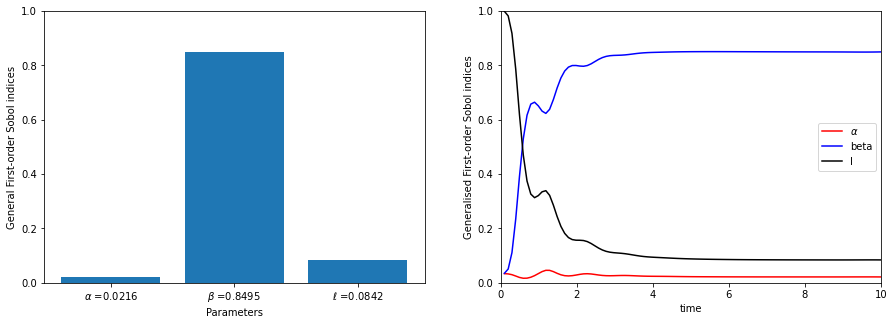

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

'Histogram of general total Sobol indices at t=T'
params = [r'$\alpha$ =' + str(np.around(G_U_evolution[0,-1], 4)), 
          r'$\beta$ =' +  str(np.around(G_U_evolution[1,-1], 4)), 
          r'$\ell$ =' +     str(np.around(G_U_evolution[2,-1], 4))]

ax[0].bar(params,G_U_evolution[:,-1])
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Parameters')
ax[0].set_ylabel('Generalised First-order Sobol indices')

'Evolution of general total Sobol indices'
ax[1].plot(t_linspace,G_U_evolution[0,:], color = 'red',   label = r'$\alpha$')
ax[1].plot(t_linspace,G_U_evolution[1,:], color = 'blue',  label = 'beta')
ax[1].plot(t_linspace,G_U_evolution[2,:], color = 'black', label = 'l')
plt.xlim(0, 10)
plt.ylim(0, 1)
ax[1].legend()
ax[1].set_xlabel('time')
ax[1].set_ylabel('Generalised First-order Sobol indices')
plt.show()

# Total Order Indices

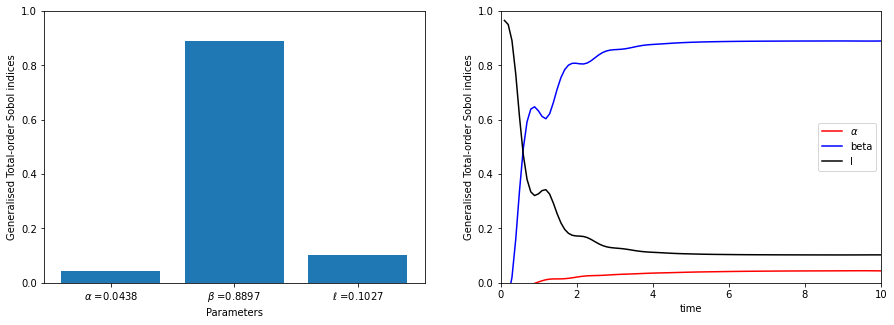

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))

'Histogram of general total Sobol indices at t=T'
params = [r'$\alpha$ =' + str(np.around(G_total_U_evolution[0,-1], 4)), 
          r'$\beta$ =' +  str(np.around(G_total_U_evolution[1,-1], 4)), 
          r'$\ell$ =' +     str(np.around(G_total_U_evolution[2,-1], 4))]

ax[0].bar(params,G_total_U_evolution[:,-1])
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Parameters')
ax[0].set_ylabel('Generalised Total-order Sobol indices')

'Evolution of general total Sobol indices'
ax[1].plot(t_linspace,G_total_U_evolution[0,:], color = 'red',   label = r'$\alpha$')
ax[1].plot(t_linspace,G_total_U_evolution[1,:], color = 'blue',  label = 'beta')
ax[1].plot(t_linspace,G_total_U_evolution[2,:], color = 'black', label = 'l')
plt.xlim(0, 10)
plt.ylim(0, 1)
ax[1].legend()
ax[1].set_xlabel('time')
ax[1].set_ylabel('Generalised Total-order Sobol indices')
plt.show()